# TQuant Lab - Piotroski F-score 策略

參考資料來源：[芝加哥大學期刊](https://www.chicagobooth.edu/~/media/FE874EE65F624AAEBD0166B1974FD74D.pdf) 
  
Piotroski F-score，又稱為皮爾托斯基分數或 F-score，是由前芝加哥大學教授 Joseph Piotroski 提出的指標。  
F-score 包含 9 項財報條件，涵蓋公司的獲利性、安全性，以及成長性，透過 F-score 我們希望找出被低估但基本面良好的股票。

本範例運用 TQuant Lab 為研究工具，以 F-score 作為選股指標建立交易策略，並回測分析其績效表現。交易策略建立流程涵蓋以下 5 個步驟：
1. 設定基本環境
2. 將交易資料導入 zipline 回測架構中
3. 建構策略
4. 回測
5. 策略績效分析

## 1. 設定基本環境

導入交易資料前，我們要先使用 `os` 設定環境變數，
``` python
os.environ['TEJAPI_KEY'] = tej_key        ==> 個人 api key 以驗證身分。
os.environ['TEJAPI_BASE'] = api_base      ==> 導航至 tej api 網域。
```

In [1]:
import os
import numpy as np
import pandas as pd

# tej_key
tej_key = 'your key'
api_base = 'https://api.tej.com.tw'

os.environ['TEJAPI_KEY'] = tej_key 
os.environ['TEJAPI_BASE'] = api_base

## 2. 將交易資料導入 zipline 回測架構中

### 2.1 選取股票池
F-score 策略旨在找出被低估的股票，因此我們挑選淨值市價比 ( Book-to-Market Ratio, BM Ratio ) 在市場前 20 % 的股票。  
我們首先利用 `get_universe` 取得在 2019 年 5 月 6 日的所有上市櫃普通股的股票代碼。

In [2]:
from zipline.sources.TEJ_Api_Data import get_universe

pool = get_universe(start = '2019-05-06', 
                    end = '2019-05-06', 
                    mkt = ['TWSE', 'OTC'],  # 上市櫃公司
                    stktp_e = ['Common Stock', 'Common Stock-Foreign']  # 普通股 & KY股
                   )

Currently used TEJ API key call quota 153/100000 (0.15%)
Currently used TEJ API key data quota 1725822/10000000 (17.26%)


In [3]:
len(pool)

1699

接著，我們使用 `Tej Tool API` 取得上述 1699 檔股票的股價淨值比 ( Price-Book Ratio, PB ratio )。  
p.s. **BM Ratio 和 PB Ratio 互為倒數**。

In [4]:
import TejToolAPI

data = TejToolAPI.get_history_data(start = '2019-05-06', 
                                   end = '2019-05-06',
                                   ticker = pool, 
                                   columns = ['PBR_TEJ'],  
                                   transfer_to_chinese = False
                                   )
data

Currently used TEJ API key call quota 224/100000 (0.22%)
Currently used TEJ API key data quota 1939433/10000000 (19.39%)


,coid,mdate,PBR_TEJ
0,1101,2019-05-06,1.2701
1,1102,2019-05-06,1.0117
2,1103,2019-05-06,0.5626
3,1104,2019-05-06,0.7271
4,1108,2019-05-06,0.6518
...,...,...,...
1694,9951,2019-05-06,2.5846
1695,9955,2019-05-06,0.7359
1696,9958,2019-05-06,3.7914
1697,9960,2019-05-06,2.2604


In [5]:
# 計算 BM Ratio = 1/PB Ratio
data['BM_ratio'] = 1/data['PBR_TEJ'] 
data

,coid,mdate,PBR_TEJ,BM_ratio
0,1101,2019-05-06,1.2701,0.787340
1,1102,2019-05-06,1.0117,0.988435
2,1103,2019-05-06,0.5626,1.777462
3,1104,2019-05-06,0.7271,1.375327
4,1108,2019-05-06,0.6518,1.534213
...,...,...,...,...
1694,9951,2019-05-06,2.5846,0.386907
1695,9955,2019-05-06,0.7359,1.358880
1696,9958,2019-05-06,3.7914,0.263755
1697,9960,2019-05-06,2.2604,0.442400


In [6]:
# 計算 BM Ratio 的 80 分位數
quantile_80 = data['BM_ratio'].quantile(0.80)

# 選取 BM Ratio 前 20% 的資料
top_20_percert_data = data[data['BM_ratio'] >= quantile_80]
top_20_percert_data

,coid,mdate,PBR_TEJ,BM_ratio
2,1103,2019-05-06,0.5626,1.777462
3,1104,2019-05-06,0.7271,1.375327
4,1108,2019-05-06,0.6518,1.534213
12,1217,2019-05-06,0.6257,1.598210
22,1234,2019-05-06,0.7265,1.376462
...,...,...,...,...
1657,9902,2019-05-06,0.7575,1.320132
1665,9912,2019-05-06,0.7765,1.287830
1689,9944,2019-05-06,0.6019,1.661406
1692,9949,2019-05-06,0.7847,1.274372


In [7]:
# 取得 BM Ratio 在市場前 20% 的股票 -> pool
pool = top_20_percert_data['coid'].tolist()
pool

['1103',
 '1104',
 '1108',
 '1217',
 '1234',
 '1235',
 '1236',
 '1262',
 '1304',
 '1308',
 '1309',
 '1313',
 '1314',
 '1315',
 '1324',
 '1325',
 '1333',
 '1336',
 '1337',
 '1339',
 '1340',
 '1402',
 '1409',
 '1414',
 '1416',
 '1417',
 '1423',
 '1432',
 '1434',
 '1435',
 '1437',
 '1440',
 '1441',
 '1443',
 '1445',
 '1447',
 '1449',
 '1451',
 '1453',
 '1454',
 '1455',
 '1456',
 '1459',
 '1466',
 '1471',
 '1474',
 '1504',
 '1517',
 '1524',
 '1528',
 '1531',
 '1538',
 '1569',
 '1584',
 '1605',
 '1612',
 '1616',
 '1618',
 '1714',
 '1718',
 '1724',
 '1725',
 '1802',
 '1806',
 '1809',
 '1810',
 '1905',
 '1906',
 '1907',
 '2007',
 '2010',
 '2017',
 '2022',
 '2023',
 '2025',
 '2029',
 '2032',
 '2033',
 '2038',
 '2064',
 '2102',
 '2107',
 '2201',
 '2204',
 '2243',
 '2303',
 '2305',
 '2316',
 '2323',
 '2324',
 '2331',
 '2354',
 '2359',
 '2362',
 '2363',
 '2365',
 '2369',
 '2374',
 '2380',
 '2387',
 '2393',
 '2399',
 '2401',
 '2402',
 '2406',
 '2409',
 '2417',
 '2430',
 '2443',
 '2448',
 '2453',
 

### 2.2 取得計算 F-score 需要的財務資料 

F-score 共有 9 項不同的基本面條件，符合一項得 1 分，總分共 9 分。  
**我們將買入 8 分和 9 分的標的，並在每季進行一次再平衡。**  
F-score 的 9 項基本面條件如下：

- **獲利性**
  1. 資產報酬率 ( ROA ) > 0
  2. 今年 ROA > 去年 ROA
  3. 今年的營業現金流 > 0
  4. 營業現金流 > 稅後淨利


- **安全性**
  1. 今年度的長期負債金額 < 上一年度
  2. 今年度的流動比率 > 上一年度
  3. 上一年度沒有發行新股
 
- **成長性**
  1. 今年度的毛利率 > 上一年度
  2. 今年度的資產週轉率 > 上一年度
 
根據計算 F-score 所需的基本面條件，我們使用 `Tej Tool API` 抓取以下 9 項財務資料：
1. **ROA**: Return_on_Total_Assets_A_percent
2. **營業現金流**：Cash_Flow_from_Operating_Activities
3. **每股稅後淨利**：Net_Income_Per_Share
4. **在外流通股數_仟股**：Outstanding_Shares_1000_Shares
5. **長期負債**：Total_Non_current_Liabilities
6. **流動比率**：Current_Ratio
7. **現金增資_仟股**：Cash_Capital_Increase_Thousand_Shares
8. **營業毛利率**：Gross_Margin_Rate_percent
9. **資產週轉率**：Total_Assets_Turnover

In [8]:
start = '2019-05-06'
end = '2023-12-31'

columns = ['Return_on_Total_Assets_A_percent',
           'Cash_Flow_from_Operating_Activities',
           'Net_Income_Per_Share',
           'Outstanding_Shares_1000_Shares',
           'Total_Non_current_Liabilities',
           'Current_Ratio',
           'Cash_Capital_Increase_Thousand_Shares',
           'Gross_Margin_Rate_percent', 
           'Total_Assets_Turnover']

fin_data = TejToolAPI.get_history_data(start = start, 
                                       end = end,
                                       ticker = pool, 
                                       columns = columns,
                                       transfer_to_chinese = False
                                       )

fin_data

Currently used TEJ API key call quota 293/100000 (0.29%)
Currently used TEJ API key data quota 2275128/10000000 (22.75%)


,coid,mdate,Outstanding_Shares_1000_Shares,Total_Non_current_Liabilities_A,Total_Non_current_Liabilities_Q,Total_Non_current_Liabilities_TTM,Gross_Margin_Rate_percent_A,Gross_Margin_Rate_percent_Q,Gross_Margin_Rate_percent_TTM,Current_Ratio_A,...,Total_Assets_Turnover_A,Total_Assets_Turnover_Q,Total_Assets_Turnover_TTM,Cash_Flow_from_Operating_Activities_A,Cash_Flow_from_Operating_Activities_Q,Cash_Flow_from_Operating_Activities_TTM,Net_Income_Per_Share_A,Net_Income_Per_Share_Q,Net_Income_Per_Share_TTM,Cash_Capital_Increase_Thousand_Shares
0,1103,2019-05-06,774781.0,7870414.0,7870414.0,7870414.0,13.79,11.56,3.35,348.97,...,0.07,0.02,0.07,-506413.0,39084.0,-506413.0,0.99,-0.27,0.99,NaN
1,1104,2019-05-06,653609.0,1311820.0,1311820.0,1311820.0,11.94,12.33,11.94,118.14,...,0.22,0.06,0.22,602424.0,90982.0,602424.0,1.61,0.46,1.61,NaN
2,1108,2019-05-06,404738.0,1330430.0,1330430.0,1330430.0,1.40,-2.62,1.52,284.47,...,0.46,0.12,0.46,51832.0,-13448.0,51832.0,-0.50,-0.37,-0.50,NaN
3,1217,2019-05-06,494513.0,2932952.0,2932952.0,2932952.0,31.94,27.90,48.67,59.52,...,0.35,0.06,0.35,430382.0,369565.0,430382.0,0.13,-0.03,0.13,NaN
4,1234,2019-05-06,401871.0,2390462.0,2390462.0,2390462.0,23.79,12.88,32.94,255.14,...,0.39,0.08,0.39,461274.0,519782.0,461274.0,1.73,0.30,1.73,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377281,9902,2023-12-29,98050.0,33901.0,33901.0,33901.0,6.60,9.52,5.52,887.24,...,0.08,0.03,0.16,-64490.0,-17646.0,-62917.0,0.20,0.01,0.21,NaN
377282,9912,2023-12-29,55219.0,4200.0,4200.0,4200.0,40.05,39.65,36.97,130.01,...,0.50,0.18,0.65,54730.0,26463.0,93283.0,-0.56,-0.14,-0.87,0.0
377283,9944,2023-12-29,109107.0,1079712.0,1079712.0,1079712.0,23.12,16.58,23.84,246.11,...,0.27,0.07,0.37,57256.0,69645.0,166132.0,1.78,-0.55,3.39,NaN
377284,9949,2023-12-29,44033.0,18132.0,18132.0,18132.0,67.13,68.55,63.93,463.52,...,0.26,0.07,0.43,-9383.0,-6312.0,4645.0,-0.64,-0.20,-0.50,0.0


In [9]:
fin_data = fin_data.sort_values(['coid','mdate'])
fin_data = fin_data.filter(regex='(_TTM$|^(?!.*(_A$|_Q$|_TTM$)).*$)')  # 僅保留移動四季 (TTM) 的資料
fin_data['Net_Income'] = fin_data['Outstanding_Shares_1000_Shares'] * fin_data['Net_Income_Per_Share_TTM']
fin_data

,coid,mdate,Outstanding_Shares_1000_Shares,Total_Non_current_Liabilities_TTM,Gross_Margin_Rate_percent_TTM,Current_Ratio_TTM,Return_on_Total_Assets_A_percent_TTM,Total_Assets_Turnover_TTM,Cash_Flow_from_Operating_Activities_TTM,Net_Income_Per_Share_TTM,Cash_Capital_Increase_Thousand_Shares,Net_Income
0,1103,2019-05-06,774781.0,7870414.0,3.35,348.97,0.17,0.07,-506413.0,0.99,NaN,767033.19
50,1103,2019-05-07,774781.0,7870414.0,3.35,348.97,0.17,0.07,-506413.0,0.99,NaN,767033.19
100,1103,2019-05-08,774781.0,7870414.0,3.35,348.97,0.17,0.07,-506413.0,0.99,NaN,767033.19
150,1103,2019-05-09,774781.0,7870414.0,3.35,348.97,0.17,0.07,-506413.0,0.99,NaN,767033.19
200,1103,2019-05-10,774781.0,7870414.0,3.35,348.97,0.17,0.07,-506413.0,0.99,NaN,767033.19
...,...,...,...,...,...,...,...,...,...,...,...,...
377125,9955,2023-12-25,103208.0,785288.0,2.98,83.10,-2.53,0.39,55310.0,-0.80,NaN,-82566.40
377165,9955,2023-12-26,103208.0,785288.0,2.98,83.10,-2.53,0.39,55310.0,-0.80,NaN,-82566.40
377205,9955,2023-12-27,103208.0,785288.0,2.98,83.10,-2.53,0.39,55310.0,-0.80,NaN,-82566.40
377245,9955,2023-12-28,103208.0,785288.0,2.98,83.10,-2.53,0.39,55310.0,-0.80,NaN,-82566.40


### 2.3 取得股票池價量資料

In [10]:
os.environ['mdate'] = start + ' ' + end
os.environ['ticker'] = ' '.join(pool) + ' ' + 'IR0001'

!zipline ingest -b tquant

Merging daily equity files:
Currently used TEJ API key call quota 305/100000 (0.3%)
Currently used TEJ API key data quota 3451303/10000000 (34.51%)


[2024-05-31 03:01:01.763050] INFO: zipline.data.bundles.core: Ingesting tquant.
[2024-05-31 03:01:51.783357] INFO: zipline.data.bundles.core: Ingest tquant successfully.


## 3. 建構策略

本章節將運用`zipline.pipeline`的相關函數來建立交易策略的買賣訊號。  
流程如下：  
**(1)** 定義 `CustomDataset` 函數: 定義策略需要的基本面變數。<br>
**(2)** 使用 `DataFrameLoader` 函數，將第二節中用`TejToolAPI`函數抓取的基本面資料寫入`CustomDataset`函數定義的變數。<br>
**(3)** 設定 `choose_loader` 函數來指定資料欄位分別要從哪個來源抓取。<br>
**(4)** 使用 `CustomFactor` 函數定義計算 F-score 需要的因子。<br>
**(4)** 定義 `make_pipeline` 函數來計算 F-score，並將 **8 分和 9 分** 的標的轉換為**買進**交易訊號。<br> 
**(5)** 最後利用 `run_pipeline` 函數產出買賣訊號整合成 DataFrame 輸出。<br> 

In [11]:
from zipline.data import bundles

bundle_name = 'tquant'
bundle = bundles.load(bundle_name)

In [12]:
from zipline.pipeline.data.dataset import Column, DataSet
from zipline.pipeline.domain import TW_EQUITIES

class CustomDataset(DataSet):
    
    Return_on_Total_Assets_A_percent_TTM = Column(dtype=float)
    Cash_Flow_from_Operating_Activities_TTM = Column(dtype=float)
    Net_Income = Column(dtype=float)
    Total_Non_current_Liabilities_TTM = Column(dtype=float)
    Current_Ratio_TTM = Column(dtype=float)
    Cash_Capital_Increase_Thousand_Shares = Column(dtype=float)
    Gross_Margin_Rate_percent_TTM = Column(dtype=float)
    Total_Assets_Turnover_TTM = Column(dtype=float)

    domain = TW_EQUITIES

In [13]:
sids = bundle.asset_finder.equities_sids
assets = bundle.asset_finder.retrieve_all(sids)
symbol_mapping_sid = {i.symbol:i.sid for i in assets}

In [14]:
transform_data = fin_data.set_index(['coid', 'mdate']).unstack('coid')
transform_data = transform_data.rename(columns = symbol_mapping_sid)
transform_data.index = transform_data.index.tz_localize('UTC')
transform_data

Outstanding_Shares_1000_Shares                      \
coid                                                 0         1         2     
mdate                                                                          
2019-05-06 00:00:00+00:00                       774781.0  653609.0  404738.0   
2019-05-07 00:00:00+00:00                       774781.0  653609.0  404738.0   
2019-05-08 00:00:00+00:00                       774781.0  653609.0  404738.0   
2019-05-09 00:00:00+00:00                       774781.0  653609.0  404738.0   
2019-05-10 00:00:00+00:00                       774781.0  653609.0  404738.0   
...                                                  ...       ...       ...   
2023-12-25 00:00:00+00:00                       790247.0  673217.0  404738.0   
2023-12-26 00:00:00+00:00                       790247.0  673217.0  404738.0   
2023-12-27 00:00:00+00:00                       790247.0  673217.0  404738.0   
2023-12-28 00:00:00+00:00                       790247.0  673217.0  404738.0   
2023-12-29 00:00:00+00:00                       790247.0  673217.0  404738.0   

                                                                             \
coid                            3         4         5         6         7     
mdate                                                                         
2019-05-06 00:00:00+00:00  494513.0  401871.0   98955.0  108343.0  163350.0   
2019-05-07 00:00:00+00:00  494513.0  401871.0   98955.0  108343.0  163350.0   
2019-05-08 00:00:00+00:00  494513.0  401871.0   98955.0  108343.0  163350.0   
2019-05-09 00:00:00+00:00  494513.0  401871.0   98955.0  108343.0  163350.0   
2019-05-10 00:00:00+00:00  494513.0  401871.0   98955.0  108343.0  163350.0   
...                             ...       ...       ...       ...       ...   
2023-12-25 00:00:00+00:00  494513.0  401871.0  149665.0   86674.0       NaN   
2023-12-26 00:00:00+00:00  494513.0  401871.0  149665.0   86674.0       NaN   
2023-12-27 00:00:00+00:00  494513.0  401871.0  149665.0   86674.0       NaN   
2023-12-28 00:00:00+00:00  494513.0  401871.0  149665.0   86674.0       NaN   
2023-12-29 00:00:00+00:00  494513.0  401871.0  149665.0   86674.0       NaN   

                                                ... Net_Income            \
coid                             8         9    ...        330       331   
mdate                                           ...                        
2019-05-06 00:00:00+00:00  1188764.0  554383.0  ...  -201150.0  226936.0   
2019-05-07 00:00:00+00:00  1188764.0  554383.0  ...  -201150.0  226936.0   
2019-05-08 00:00:00+00:00  1188764.0  554383.0  ...  -201150.0  226936.0   
2019-05-09 00:00:00+00:00  1188764.0  554383.0  ...  -201150.0  176771.2   
2019-05-10 00:00:00+00:00  1188764.0  554383.0  ...  -201150.0  176771.2   
...                              ...       ...  ...        ...       ...   
2023-12-25 00:00:00+00:00  1188764.0  593744.0  ...   -74235.0  280684.0   
2023-12-26 00:00:00+00:00  1188764.0  593744.0  ...   -74235.0  280684.0   
2023-12-27 00:00:00+00:00  1188764.0  593744.0  ...   -74235.0  280684.0   
2023-12-28 00:00:00+00:00  1188764.0  593744.0  ...   -74235.0  280684.0   
2023-12-29 00:00:00+00:00  1188764.0  593744.0  ...   -74235.0  280684.0   

                                                                               \
coid                            332         333        334      335       336   
mdate                                                                           
2019-05-06 00:00:00+00:00  14443.52 -1616331.90  195576.00  11766.0  12500.73   
2019-05-07 00:00:00+00:00  14443.52 -1616331.90  195576.00  11766.0  12500.73   
2019-05-08 00:00:00+00:00  14443.52 -1616331.90  195576.00  11766.0  12500.73   
2019-05-09 00:00:00+00:00  14443.52 -1616331.90  195576.00  11766.0  12500.73   
2019-05-10 00:00:00+00:00  14443.52 -1616331.90  195576.00  11766.0  12500.73   
...                             ...         ...        ...      ...       ...   
2023

In [15]:
from zipline.pipeline.loaders.frame import DataFrameLoader

custom_loader = {}

inputs=[CustomDataset.Return_on_Total_Assets_A_percent_TTM,
        CustomDataset.Cash_Flow_from_Operating_Activities_TTM,
        CustomDataset.Net_Income,
        CustomDataset.Total_Non_current_Liabilities_TTM,
        CustomDataset.Current_Ratio_TTM,
        CustomDataset.Cash_Capital_Increase_Thousand_Shares,
        CustomDataset.Gross_Margin_Rate_percent_TTM,
        CustomDataset.Total_Assets_Turnover_TTM,
        ]

for i in inputs:
    custom_loader[i]=DataFrameLoader(column=i,
                                     baseline=transform_data[i.name])
custom_loader

{CustomDataset<TW>.Return_on_Total_Assets_A_percent_TTM::float64: <zipline.pipeline.loaders.frame.DataFrameLoader at 0x1f4843793f0>,
 CustomDataset<TW>.Cash_Flow_from_Operating_Activities_TTM::float64: <zipline.pipeline.loaders.frame.DataFrameLoader at 0x1f48437a560>,
 CustomDataset<TW>.Net_Income::float64: <zipline.pipeline.loaders.frame.DataFrameLoader at 0x1f48622bdc0>,
 CustomDataset<TW>.Total_Non_current_Liabilities_TTM::float64: <zipline.pipeline.loaders.frame.DataFrameLoader at 0x1f486229a50>,
 CustomDataset<TW>.Current_Ratio_TTM::float64: <zipline.pipeline.loaders.frame.DataFrameLoader at 0x1f48622b7f0>,
 CustomDataset<TW>.Cash_Capital_Increase_Thousand_Shares::float64: <zipline.pipeline.loaders.frame.DataFrameLoader at 0x1f48622b340>,
 CustomDataset<TW>.Gross_Margin_Rate_percent_TTM::float64: <zipline.pipeline.loaders.frame.DataFrameLoader at 0x1f486229a20>,
 CustomDataset<TW>.Total_Assets_Turnover_TTM::float64: <zipline.pipeline.loaders.frame.DataFrameLoader at 0x1f48622b400>

In [16]:
from zipline.pipeline import SimplePipelineEngine
from zipline.pipeline.data import TWEquityPricing
from zipline.pipeline.loaders import EquityPricingLoader
pricing_loader = EquityPricingLoader.without_fx(bundle.equity_daily_bar_reader,
                                                bundle.adjustment_reader)
def choose_loader(column):
    if column.name in TWEquityPricing._column_names:
        return pricing_loader
    elif column.name in CustomDataset._column_names:     
        return custom_loader[column]
    else:
        raise Exception('Column not available')
    
engine = SimplePipelineEngine(get_loader = choose_loader,
                              asset_finder = bundle.asset_finder,
                              default_domain = TW_EQUITIES)

In [17]:
from zipline.pipeline import Pipeline, CustomFactor

# 計算年度變化量
class YOY_change(CustomFactor):
    
    def compute(self, today, assets, out, values):
        out[:] = values[-1] - values[0]

In [18]:
from zipline.pipeline.factors import Factor
from zipline.pipeline.mixins import SingleInputMixin
from zipline.utils.numpy_utils import float64_dtype
from zipline.pipeline.filters import Filter

# 將通過 filter ( F-score 條件 ) 的 F-score 條件轉為 1，沒通過的轉為 0
class BooleanFactor(SingleInputMixin, Factor):
    """
    Factor that casts a Filter of booleans to 1s and 0s. This factor can be
    created via Filter.as_factor().

    Parameters
    ----------
    filter : zipline.pipeline.Filter
        Filter producing the boolean array which will be converted to 1s and 0s.
    """
    window_length = 0
    dtype = float64_dtype

    #@validate_call(config=dict(arbitrary_types_allowed=True))
    def __new__(cls, filter: Filter):
        return super(BooleanFactor, cls).__new__(
            cls,
            inputs=(filter,),
            mask=filter.mask,
        )

    def _compute(self, arrays, dates, assets, mask):
        data = arrays[0]
        return (data & mask).astype(float)

In [19]:
from zipline.pipeline import Pipeline
from zipline.pipeline.factors import Factor, SimpleMovingAverage
from zipline.pipeline.filters import StaticAssets

benchmark_asset = bundle.asset_finder.lookup_symbol('IR0001',as_of_date = None)

def make_pipeline():

    # 導入股價與基本面資料
    price = TWEquityPricing.close.latest
    ROA = CustomDataset.Return_on_Total_Assets_A_percent_TTM.latest
    CFO = CustomDataset.Cash_Flow_from_Operating_Activities_TTM.latest
    NI = CustomDataset.Net_Income.latest
    NCL = CustomDataset.Total_Non_current_Liabilities_TTM.latest
    CR = CustomDataset.Current_Ratio_TTM.latest
    CCI = CustomDataset.Cash_Capital_Increase_Thousand_Shares.latest
    GM = CustomDataset.Gross_Margin_Rate_percent_TTM.latest
    Turnover = CustomDataset.Total_Assets_Turnover_TTM.latest

    # 計算年度變化量、年度平均現金增資(用以判斷是否發行新股)
    ROA_YOY_change = YOY_change(inputs=[CustomDataset.Return_on_Total_Assets_A_percent_TTM], window_length=252)
    NCL_YOY_change = YOY_change(inputs=[CustomDataset.Total_Non_current_Liabilities_TTM], window_length=252)
    CR_YOY_change = YOY_change(inputs=[CustomDataset.Current_Ratio_TTM], window_length=252)
    CCI_ave_vol = SimpleMovingAverage(inputs=[CustomDataset.Cash_Capital_Increase_Thousand_Shares], window_length=252)
    GM_YOY_change = YOY_change(inputs=[CustomDataset.Gross_Margin_Rate_percent_TTM], window_length=252)
    Turnover_YOY_change = YOY_change(inputs=[CustomDataset.Total_Assets_Turnover_TTM], window_length=252)

    # 計算 F-score 的 filters
    f_score_ROA = ROA > 0
    f_score_diff_ROA = ROA_YOY_change > 0
    f_score_CFO = CFO > 0
    f_score_CFO_NI = CFO > NI
    f_score_diff_NCL = NCL_YOY_change < 0
    f_score_diff_CR = CR_YOY_change > 0
    f_score_CCI = CCI_ave_vol > 0
    f_score_diff_GM = GM_YOY_change > 0
    f_score_Turnover = Turnover_YOY_change > 0
    
    # 計算 F-score
    # "~": 代表相反。~f_score_CCI 為年度平均新股發行數量"不"大於 0，即本年度無發行新股
    f_score_total = BooleanFactor(f_score_ROA) +\
                    BooleanFactor(f_score_diff_ROA) +\
                    BooleanFactor(f_score_CFO) + \
                    BooleanFactor(f_score_CFO_NI) +\
                    BooleanFactor(f_score_diff_NCL) +\
                    BooleanFactor(f_score_diff_CR) +\
                    BooleanFactor(~f_score_CCI) +\
                    BooleanFactor(f_score_diff_GM) +\
                    BooleanFactor(f_score_Turnover)
    
    
    return Pipeline(
        columns = {
            'price': price,
            'f_score_total': f_score_total,
            'longs': f_score_total >= 8
                },
            screen = ~StaticAssets([benchmark_asset])  # 排除大盤的數據  
    )

start_dt = pd.Timestamp(start, tz = 'UTC')
end_dt = pd.Timestamp(end, tz = 'UTC')
        
pipeline_result = engine.run_pipeline(make_pipeline(), start_dt, end_dt)
pipeline_result 

price  f_score_total  longs
2019-05-07 00:00:00+00:00 Equity(0 [1103])    15.05            2.0  False
                          Equity(1 [1104])    19.70            3.0  False
                          Equity(2 [1108])     7.01            3.0  False
                          Equity(3 [1217])     7.05            4.0  False
                          Equity(4 [1234])    31.70            3.0  False
...                                             ...            ...    ...
2023-12-29 00:00:00+00:00 Equity(335 [9902])  12.95            3.0  False
                          Equity(336 [9912])  10.95            5.0  False
                          Equity(337 [9944])  20.15            3.0  False
                          Equity(338 [9949])  18.00            6.0  False
                          Equity(339 [9955])  24.50            5.0  False

[376974 rows x 3 columns]

## 4. 回測

### 4.1 設定再平衡日期

首先我們利用 `get_calendar` 函數取得 *2020-05-30* 至 *2023-12-31* 的台股交易日。

In [20]:
from zipline.utils.calendar_utils import get_calendar 
cal = get_calendar('TEJ').all_sessions

start = '2020-05-30'
end = '2023-12-31'

cal = cal[(cal >= start) & (cal <= end)]

cal[-10:]

DatetimeIndex(['2023-12-18 00:00:00+00:00', '2023-12-19 00:00:00+00:00',
               '2023-12-20 00:00:00+00:00', '2023-12-21 00:00:00+00:00',
               '2023-12-22 00:00:00+00:00', '2023-12-25 00:00:00+00:00',
               '2023-12-26 00:00:00+00:00', '2023-12-27 00:00:00+00:00',
               '2023-12-28 00:00:00+00:00', '2023-12-29 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', freq='C')

定義在每年 3, 6, 9, 12 月的 15 日進行再平衡，使我們可以透過每季最新的財報數據調整持股。

In [21]:
cal = pd.DataFrame(cal).rename(columns={0:'date'})
cal['diff'] = cal['date'].transform(lambda x: x - pd.Timestamp(year=x.year, month=x.month, day=15, tz='UTC'))

In [22]:
tradeday = cal.groupby([cal['date'].dt.year, cal['date'].dt.month]).apply(lambda x: x[x['diff'].ge(pd.Timedelta(days=0))].head(1)).date.tolist()

tradeday = [str(i.date()) for i in tradeday]

tradeday = [tradeday[i] for i in range(0, len(tradeday), 3)]
tradeday

['2020-06-15',
 '2020-09-15',
 '2020-12-15',
 '2021-03-15',
 '2021-06-15',
 '2021-09-15',
 '2021-12-15',
 '2022-03-15',
 '2022-06-15',
 '2022-09-15',
 '2022-12-15',
 '2023-03-15',
 '2023-06-15',
 '2023-09-15',
 '2023-12-15']

### 4.2 視覺化累積報酬率與期間可動用現金

In [23]:
import matplotlib.pyplot as plt

def analyze(context, perf):
    
    fig = plt.figure(figsize=(16, 12))
    
    # First chart(累計報酬)
    ax = fig.add_subplot(311) 
    ax.set_title('Strategy Results') 
    ax.plot(perf['algorithm_period_return'], linestyle='-', 
                label='algorithm period return', linewidth=3.0)
    ax.plot(perf['benchmark_period_return'], linestyle='-', 
                label='benchmark period return', linewidth=3.0)
    ax.legend()
    ax.grid(True)
    
    # Second chart(ending_cash)->觀察是否超買
    ax = fig.add_subplot(312)
    ax.plot(perf['ending_cash'], 
            label='ending_cash', linestyle='-', linewidth=1.0)
    ax.axhline(y=1,c='r',linewidth=0.3)
    ax.legend()
    ax.grid(True)

### 4.3 設定回測參數並進行回測

使用 TEJ 自製的簡化版 Zipline 回測引擎 ( `TargetPercentPipeAlgo` )，輕鬆在一行內設定所有回測參數，最少只需輸入策略 pipeline 即可進行回測。  
`TargetPercentPipeAlgo` 的詳細使用說明可參考 TQuant Lab GitHub: [Simple Algorithm-TargetPercentPipeAlgo](https://github.com/tejtw/TQuant-Lab/blob/main/lecture/Simple%20Algorithm-TargetPercentPipeAlgo.ipynb)

本次策略修改的相關參數：

* 回測起迄日(start_session、end_session)：2020/05/30 ~ 2023/12/31
  
* 初始本金(capital_base)：1千萬
  
* 交易日(再平衡日)：3, 6, 9, 12 月的十五號
  
* 最大槓桿：90%
  
* 策略pipeline：唯一必要的函式，需確保輸入進的pipeline中有longs與shorts等行，才能確定要買進與賣出之目標個股

* 滑價模型：
  - 歷史成交量占比上限：15%，單一個股在歷史當日所能成交的最大上限，
     例如：台積電在 11 / 08 成交 20,000 張，設置 15% 意味著回測當時僅能成交 20,000 * 0.15 = 3,000張

  - 衝擊係數：0.01，用以反映買進賣出時對股價的衝擊，完整公式：`price * (1 + price_impact * (volume_share ** 2))`

* 手續費模型：  
  - 最低費用：預設為 20 元。
    
  - 券商手續費折扣比率：預設為 1，代表沒有折扣。
 
  - 證交稅率：預設為 0.003。

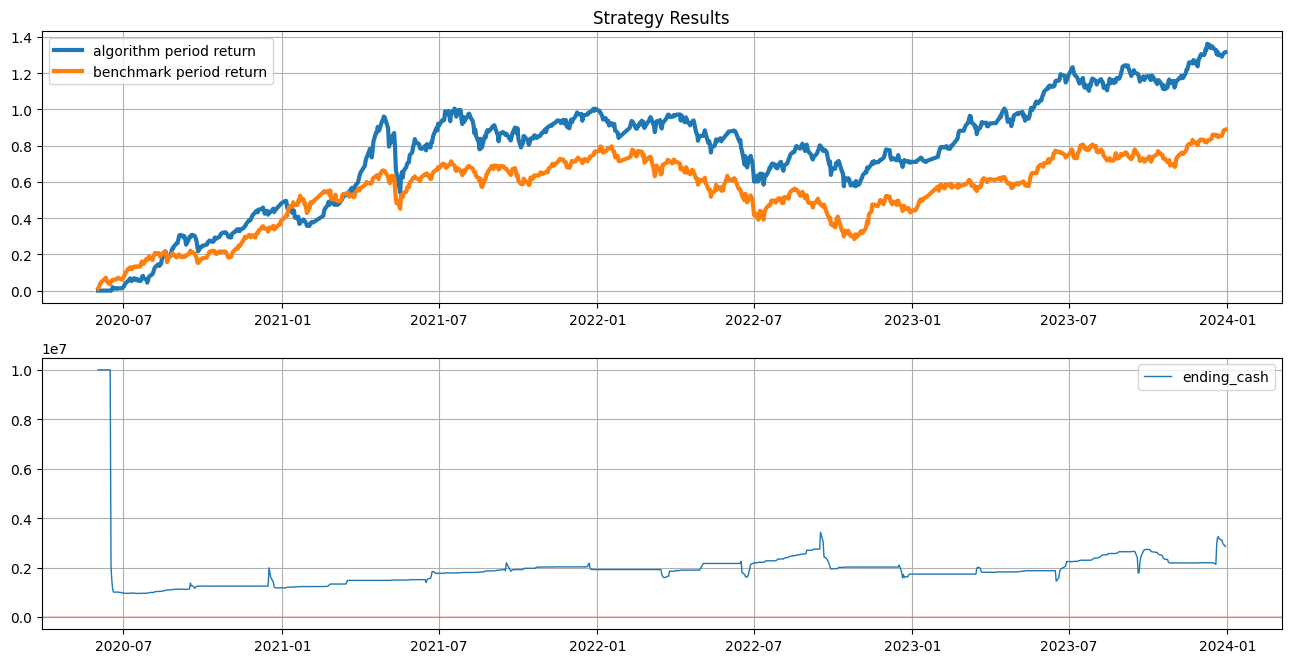

In [24]:
from zipline.algo.pipeline_algo import *

start_dt = pd.Timestamp(start, tz = 'UTC')
end_dt = pd.Timestamp(end, tz = 'UTC')

algo = TargetPercentPipeAlgo(
                     start_session=start_dt,
                     end_session=end_dt,
                     capital_base=1e7,                
                     tradeday=tradeday,
                     max_leverage=0.9,
                     pipeline=make_pipeline,
                     slippage_model=slippage.VolumeShareSlippage(volume_limit=0.15, price_impact=0.01),
                     commission_model = commission.Custom_TW_Commission(min_trade_cost = 20, discount = 1.0, tax = 0.003),
                     custom_loader=custom_loader,
                     analyze=analyze
)

results = algo.run()

In [25]:
results

,period_open,period_close,longs_count,shorts_count,long_value,short_value,long_exposure,benchmark_return,treasury_return,pnl,...,algorithm_period_return,alpha,beta,sharpe,sortino,max_drawdown,max_leverage,trading_days,period_label,algo_volatility
2020-06-01 13:30:00+08:00,2020-06-01 09:01:00+08:00,2020-06-01 13:30:00+08:00,0,0,0.00,0.0,0.00,0.012528,0.0,0.000000,...,0.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,1,2020-06,NaN
2020-06-02 13:30:00+08:00,2020-06-02 09:01:00+08:00,2020-06-02 13:30:00+08:00,0,0,0.00,0.0,0.00,0.004450,0.0,0.000000,...,0.000000,0.000000,0.000000,NaN,NaN,0.000000,0.000000,2,2020-06,0.000000
2020-06-03 13:30:00+08:00,2020-06-03 09:01:00+08:00,2020-06-03 13:30:00+08:00,0,0,0.00,0.0,0.00,0.017275,0.0,0.000000,...,0.000000,0.000000,0.000000,NaN,NaN,0.000000,0.000000,3,2020-06,0.000000
2020-06-04 13:30:00+08:00,2020-06-04 09:01:00+08:00,2020-06-04 13:30:00+08:00,0,0,0.00,0.0,0.00,0.006455,0.0,0.000000,...,0.000000,0.000000,0.000000,NaN,NaN,0.000000,0.000000,4,2020-06,0.000000
2020-06-05 13:30:00+08:00,2020-06-05 09:01:00+08:00,2020-06-05 13:30:00+08:00,0,0,0.00,0.0,0.00,0.007563,0.0,0.000000,...,0.000000,0.000000,0.000000,NaN,NaN,0.000000,0.000000,5,2020-06,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-25 13:30:00+08:00,2023-12-25 09:01:00+08:00,2023-12-25 13:30:00+08:00,18,0,19793902.17,0.0,19793902.17,0.000466,0.0,-137371.625906,...,1.290479,0.114397,0.773410,1.376035,1.871354,-0.214397,0.933098,874,2023-12,0.186436
2023-12-26 13:30:00+08:00,2023-12-26 09:01:00+08:00,2023-12-26 13:30:00+08:00,18,0,20059783.10,0.0,20059783.10,0.008348,0.0,127348.722163,...,1.303214,0.113995,0.773304,1.383725,1.881971,-0.214397,0.933098,875,2023-12,0.186345
2023-12-27 13:30:00+08:00,2023-12-27 09:01:00+08:00,2023-12-27 13:30:00+08:00,18,0,20160981.48,0.0,20160981.48,0.007874,0.0,49767.827375,...,1.308191,0.112672,0.772975,1.386266,1.885436,-0.214397,0.933098,876,2023-12,0.186240
2023-12-28 13:30:00+08:00,2023-12-28 09:01:00+08:00,2023-12-28 13:30:00+08:00,18,0,20230303.70,0.0,20230303.70,0.001055,0.0,57074.469375,...,1.313898,0.113066,0.772979,1.389281,1.889553,-0.214397,0.933098,877,2023-12,0.186135


## 5. 策略績效分析
我們將使用 `Pyfolio` 一鍵產生績效分析圖表。

### 5.1 取得詳細交易資料
使用 `extract_rets_pos_txn_from_zipline` 取出下列三表，用以計算後續各種衍生報表

- returns (日報酬率)
  
- positions (每日個股價值)
  
- transactions (交易總表)

In [26]:
import pyfolio as pf 
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(results)
benchmark_rets = results['benchmark_return']

### 5.2 績效風險視覺化

使用 `create_full_tear_sheet` 計算出完整的績效報表，例如：
  
- 累計報酬率圖表
- 最大回檔
- 前 10 大持股
- rolling beta, volatility, sharpe ratio

Start date,2020-06-01
End date,2023-12-29
Total months,41
,Backtest
Annual return,27.25%
Cumulative returns,131.546%
Annual volatility,18.603%
Sharpe ratio,1.39
Calmar ratio,1.27
Stability,0.64
Max drawdown,-21.44%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,21.44,2021-04-28,2021-05-17,2021-07-08,50
1,21.40,2021-07-19,2022-10-26,2023-04-17,424
2,9.22,2021-01-04,2021-02-01,2021-03-10,40
3,6.99,2020-09-18,2020-09-25,2020-10-21,21
4,5.92,2023-09-04,2023-10-20,2023-11-17,52


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS


Stress Events,mean,min,max
New Normal,0.10%,-6.94%,5.56%


Top 10 long positions of all time,max
sid,
3669,8.55%
1324,5.55%
2417,5.49%
6148,5.37%
4973,5.29%
2903,5.21%
2468,5.20%
4934,5.16%
3050,5.15%


Top 10 short positions of all time,max
sid,


Top 10 positions of all time,max
sid,
3669,8.55%
1324,5.55%
2417,5.49%
6148,5.37%
4973,5.29%
2903,5.21%
2468,5.20%
4934,5.16%
3050,5.15%


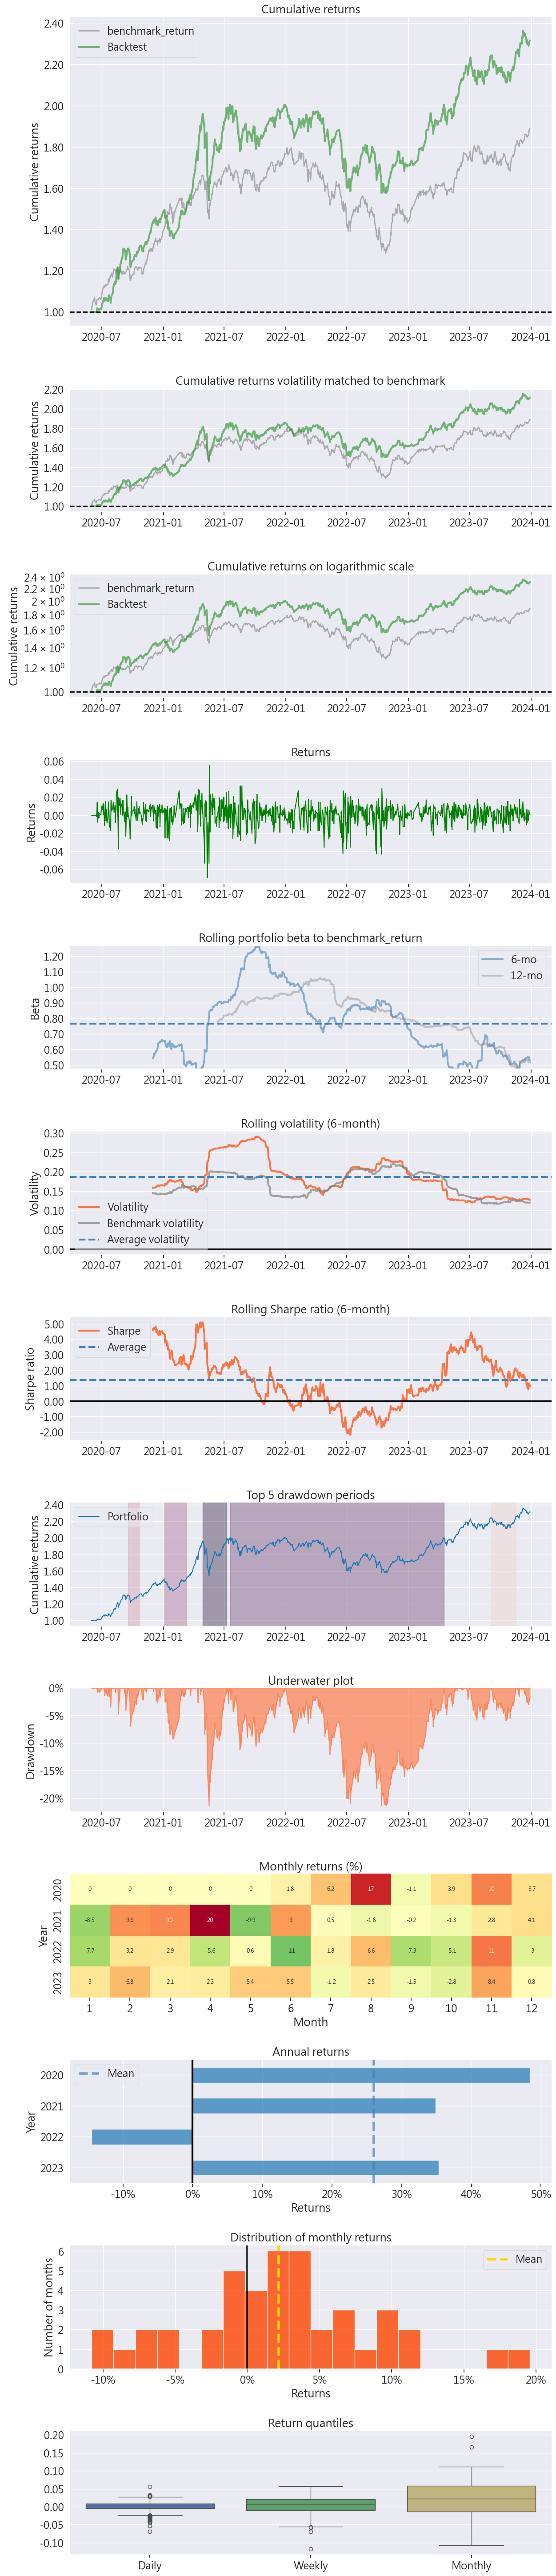

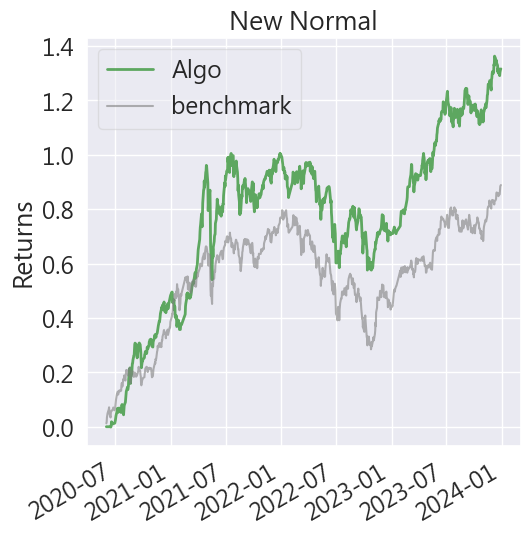

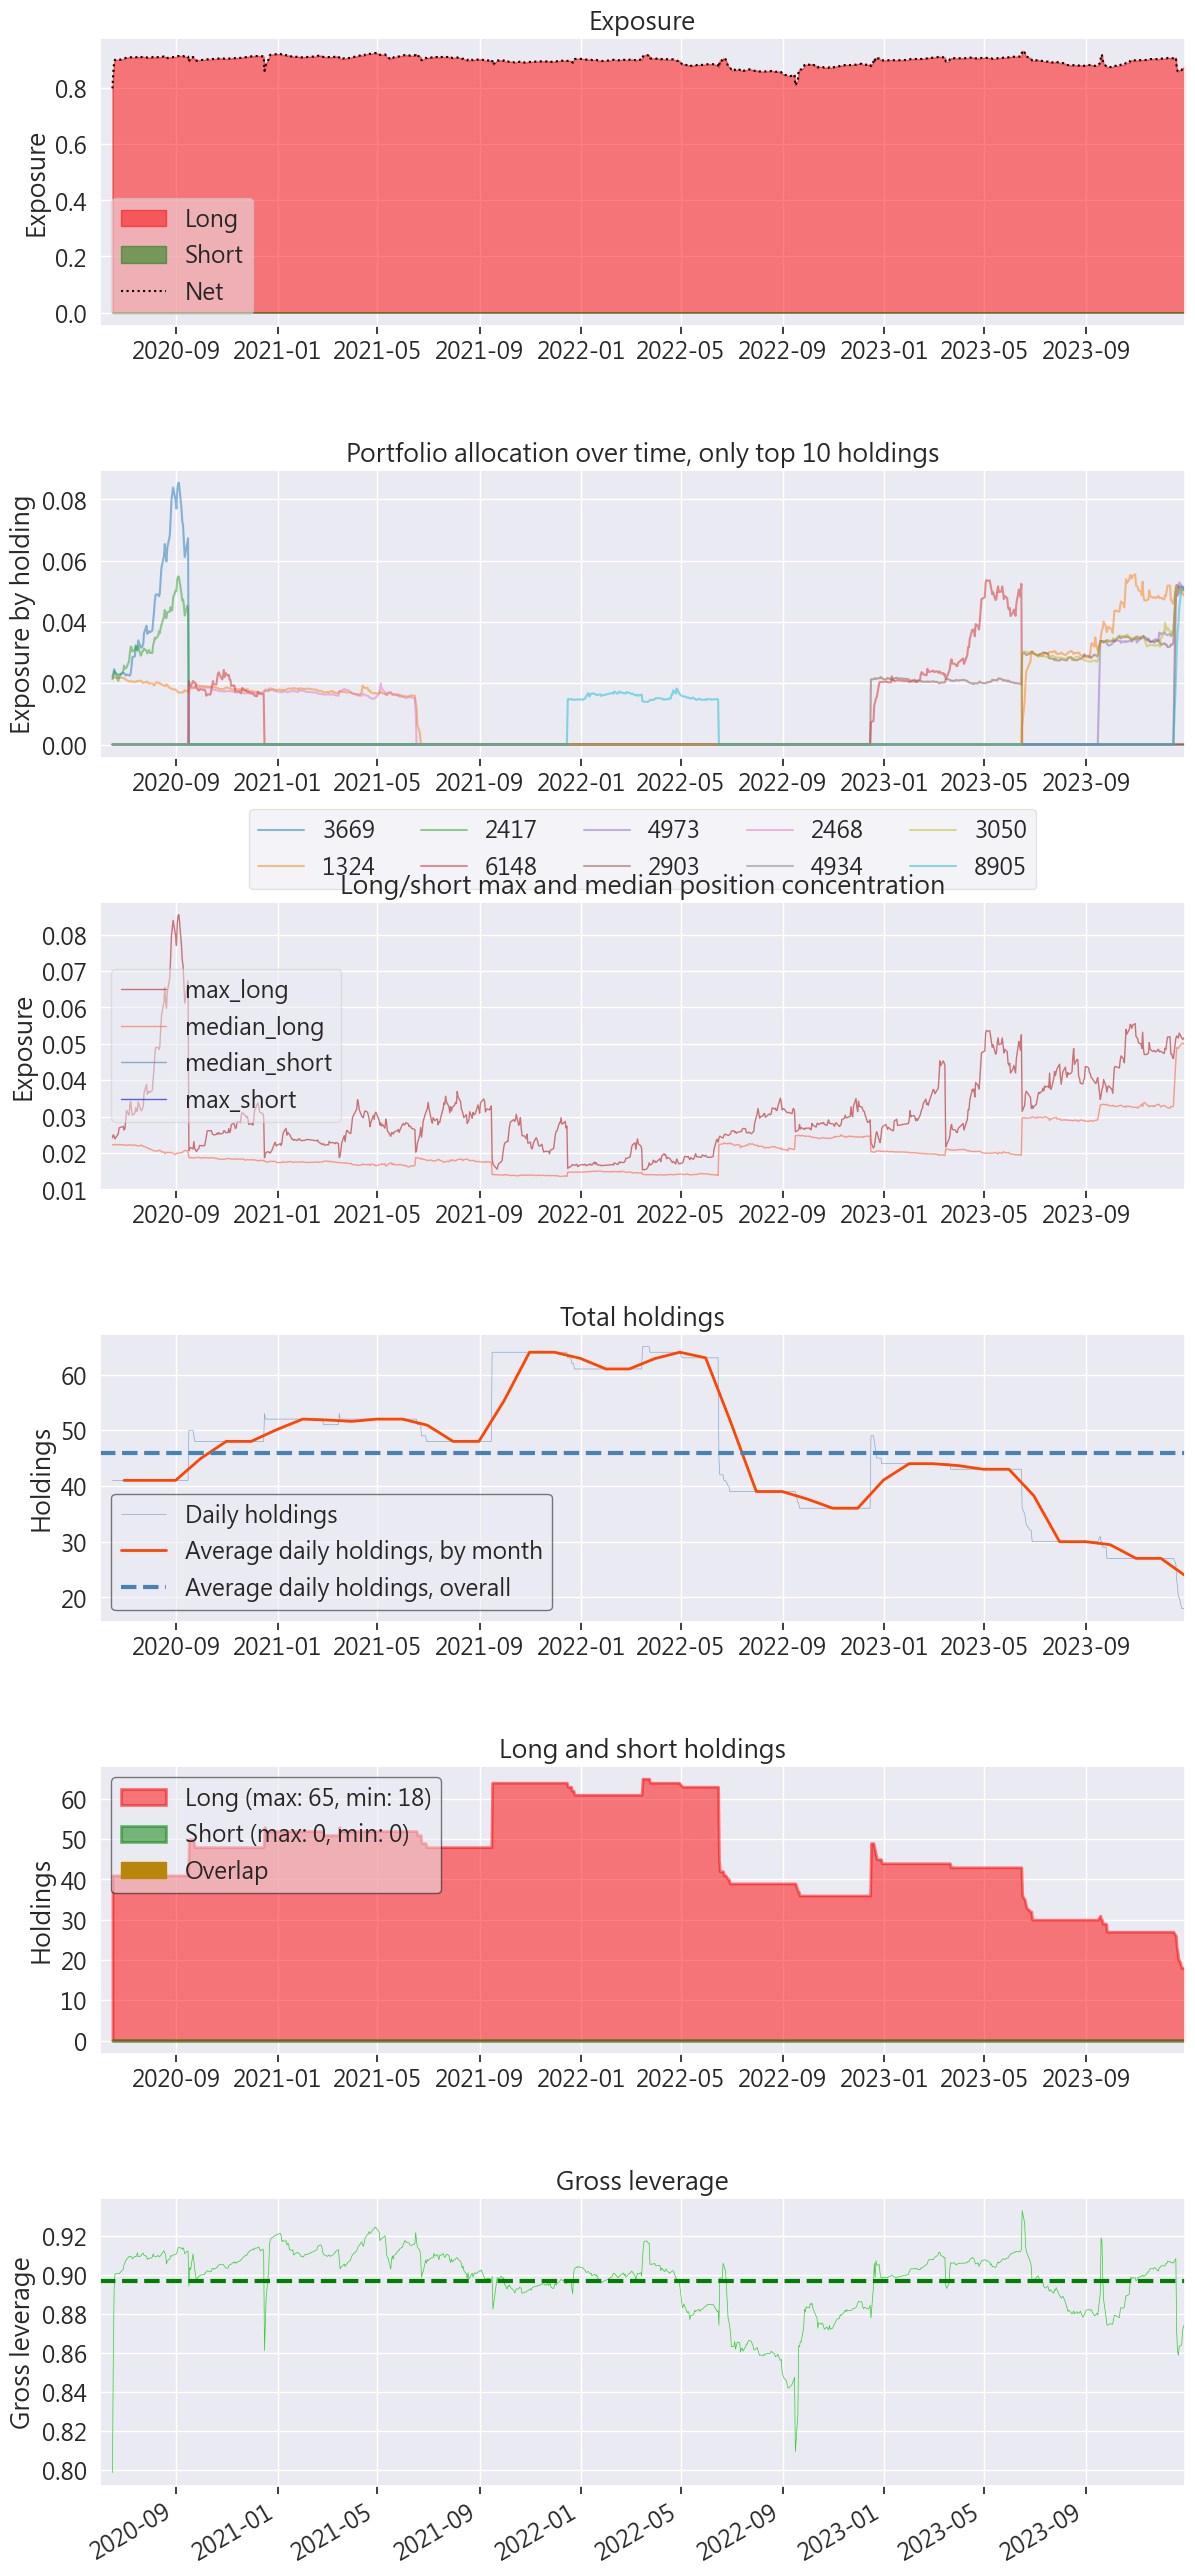

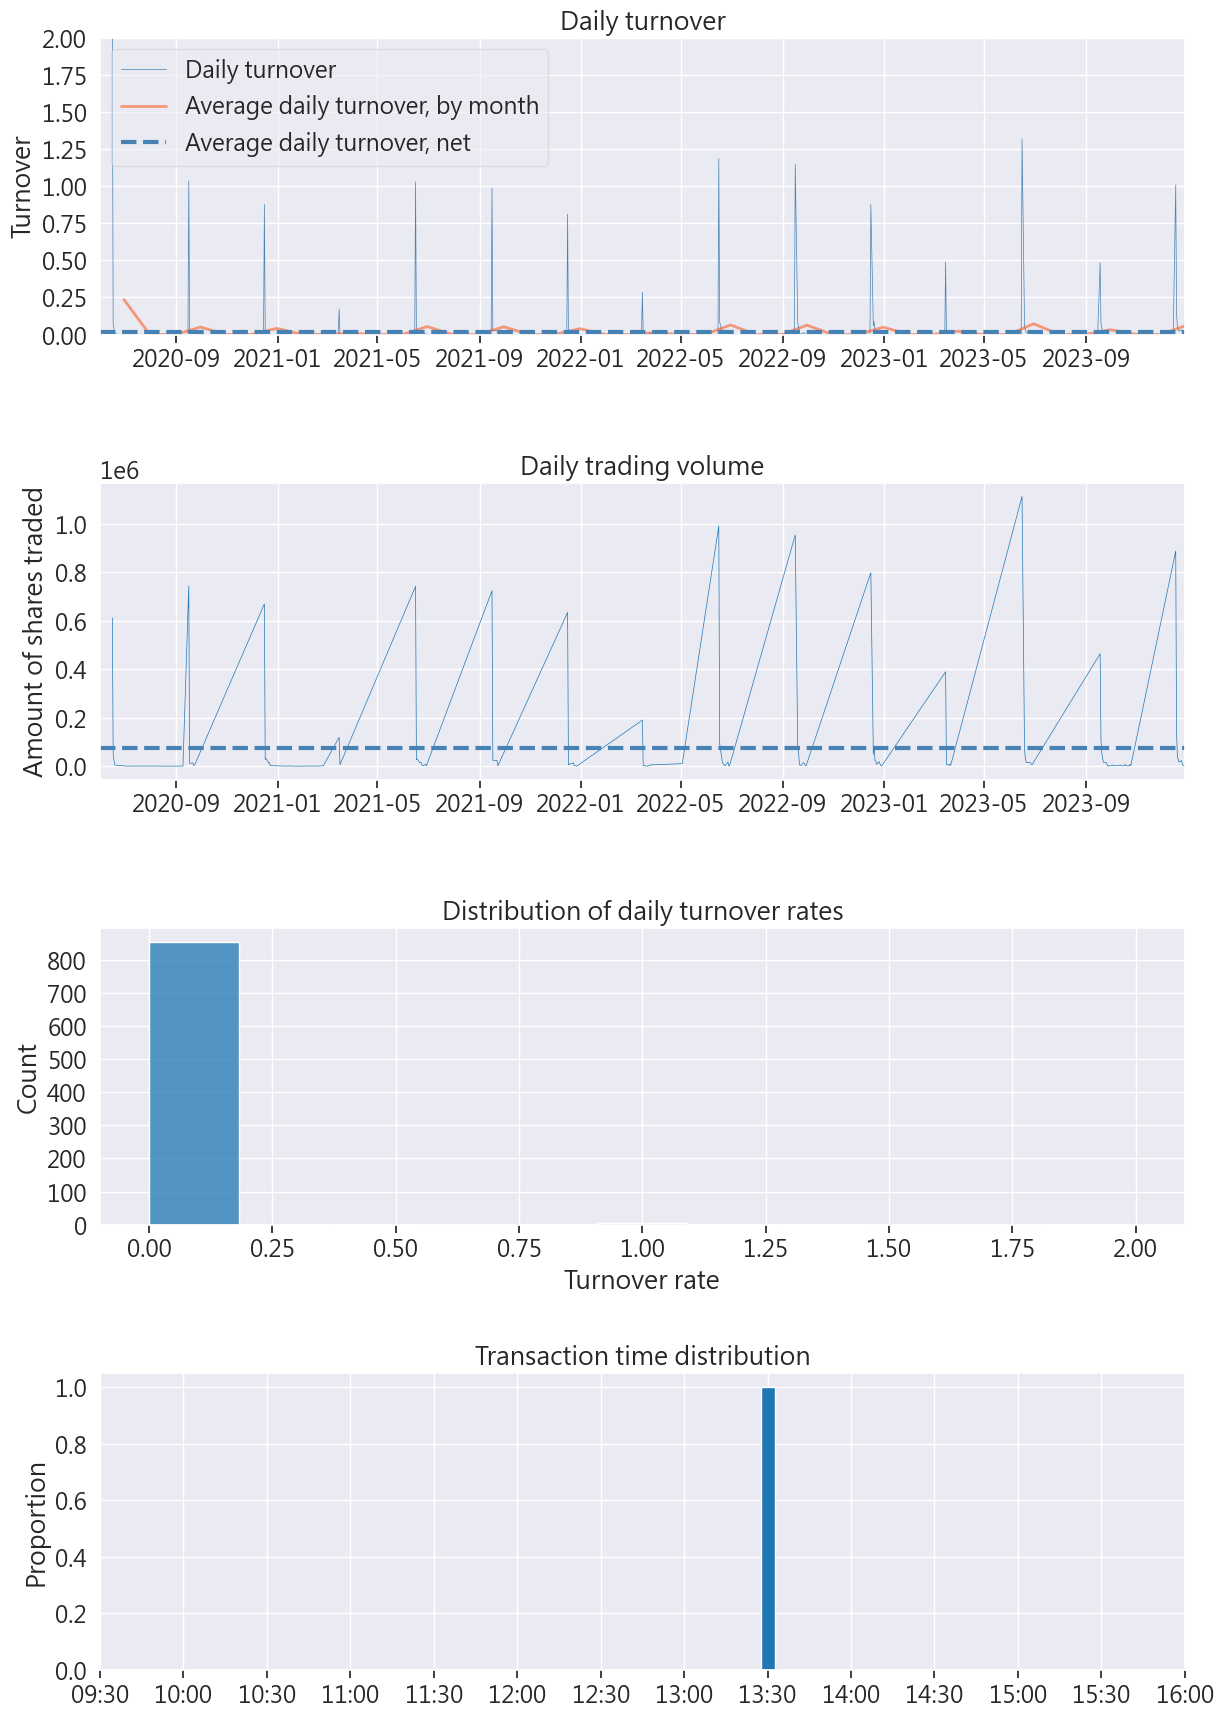

In [27]:
pf.tears.create_full_tear_sheet(returns=returns,
                                positions=positions,
                                transactions=transactions,
                                benchmark_rets=benchmark_rets
                                )